In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/spotify_genre')
models_dir = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/models'

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from src.processing import *
from src.visualization import *
from src.spotify_api import *
from src.modeling import *


from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve

import pickle

!pip install ipython-autotime
%load_ext autotime

time: 226 µs (started: 2021-08-10 20:30:07 +00:00)


In [3]:
# Import artist and track data
tracks_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/data/tracks.csv'
artists_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/data/artists.csv'
tracks_raw = pd.read_csv(tracks_path)
artists_raw = pd.read_csv(artists_path)


# Copy and process raw artist and track data
artist_split = clean_artists(artists_raw)
tracks_split = clean_tracks(tracks_raw)


# Merge artists and tracks according to desired genre specificity
total_genres = artist_split['genres'].nunique()
tracks_200_genres = top_x_genres(artist_split, tracks_split, num_genres=200)
tracks_500_genres = top_x_genres(artist_split, tracks_split, num_genres=500)
# tracks_1000_genres = top_x_genres(artist_split, tracks_split, num_genres=1000)
# tracks_all_genres = top_x_genres(artist_split, tracks_split, num_genres=total_genres)


# Remove popular genres from datasets for "obscure" training options
tracks_200_genres_obscure = top_x_genres(artist_split, tracks_split, num_genres=200, obscurity=20)
tracks_500_genres_obscure = top_x_genres(artist_split, tracks_split, num_genres=500, obscurity=20)

1104349 total artists
298616 artists with labeled genres
459962 genre-artist pairs after processing
586672 total tracks
574073 tracks with 3 or fewer artists
689217 track-artist pairs after processing
1211852 tracks from top 200 genres
1619462 tracks from top 500 genres
905672 tracks from top 200 obscure genres
1285433 tracks from top 500 obscure genres
time: 25.6 s (started: 2021-08-10 20:31:05 +00:00)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total= 2.0min
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] ..................................... max_depth=10, total= 3.5min
[CV] max_depth=15 ....................................................
[CV] ..................................... max_depth=15, total= 5.3min
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total= 2.1min
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total= 3.4min
[CV] max_depth=15 ....................................................
[CV] ..................................... max_depth=15, total= 5.2min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.1min finished


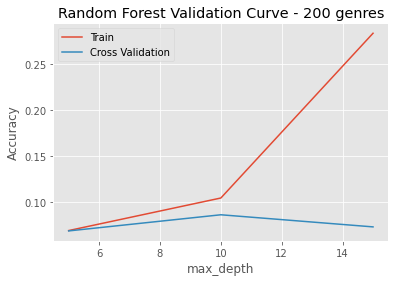

time: 27min 9s (started: 2021-08-10 19:17:43 +00:00)


In [4]:
X_train, X_test, y_train, y_test = track_features_and_labels(tracks_200_genres)

max_d = np.arange(5,16,5)

train_score, test_score = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.values.ravel(), 
                                param_name = 'max_depth', verbose = 2,
                                param_range = max_d, cv = 2)

# best max_depth appears to be 15 for 50 genres

train_scores_mean = np.mean(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)

images_dir = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img'


fig, ax = plt.subplots()
ax.plot(max_d, train_scores_mean, label='Train')
ax.plot(max_d, test_scores_mean, label='Cross Validation')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.legend()
plt.title('Random Forest Validation Curve - 200 genres')
plt.savefig(f"{images_dir}/rf_validation_depth_200.png")

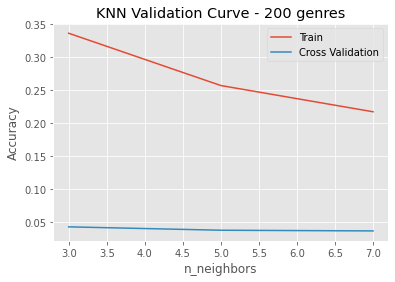

time: 330 ms (started: 2021-08-10 20:03:17 +00:00)


In [8]:
# X_train, X_test, y_train, y_test = track_features_and_labels(tracks_200_genres)

# neighbors = np.arange(3,8,2)

# train_score2, test_score2 = validation_curve(
#                                 KNeighborsClassifier(),
#                                 X = X_train, y = y_train.values.ravel(), 
#                                 param_name = 'n_neighbors', verbose = 2,
#                                 param_range = neighbors, cv = 2)

# # best max_depth appears to be 15 for 50 genres

# train_scores_mean2 = np.mean(train_score2, axis=1)
# test_scores_mean2 = np.mean(test_score2, axis=1)

images_dir = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img'


fig, ax = plt.subplots()
ax.plot(neighbors, train_scores_mean2, label='Train')
ax.plot(neighbors, test_scores_mean2, label='Cross Validation')
ax.set_xlabel('n_neighbors')
ax.set_ylabel('Accuracy')
ax.legend()
plt.title('KNN Validation Curve - 200 genres')
plt.savefig(f"{images_dir}/knn_validation_neighbors_200.png")

In [ ]:
# test song: Polo & Pan, Pays imaginaire
https://open.spotify.com/track/7i5I4h7r2vkI2r9tgKjy0x?si=cb43520c5b634c8f

# Spotify access token
BQAdUxbsRv455UZ5svflnDVMIbncLvza6W1zVr6tpJH0Vbl1faSvbLB84QSzJsduLrXxTWMqmeMleuXQk4nqVU4JxhxNVX5lI0xoCO6F-hGWnfYtOFceLuXSBHP8nRJBBvQI6ORXvRgqU8X13Q

In [ ]:
# Compare normal and obscure models -- Random Forest
rf_200 = pickle.load(open(f'{models_dir}/rf_200.pkl', 'rb'))
rf_200_obscure = pickle.load(open(f'{models_dir}/rf_200_obscure.pkl', 'rb'))

track_genre_predictions(url_to_features(), rf_200)
track_genre_predictions(url_to_features(), rf_200_obscure)



rf_500 = pickle.load(open(f'{models_dir}/rf_500.pkl', 'rb'))
rf_500_obscure = pickle.load(open(f'{models_dir}/rf_500_obscure.pkl', 'rb'))

track_genre_predictions(url_to_features(), rf_500)
track_genre_predictions(url_to_features(), rf_500_obscure)

In [ ]:
# Compare normal and obscure models -- KNN
knn_200 = pickle.load(open(f'{models_dir}/knn_200.pkl', 'rb'))
knn_200_obscure = pickle.load(open(f'{models_dir}/knn_200_obscure.pkl', 'rb'))

track_genre_predictions(url_to_features(), knn_200)
track_genre_predictions(url_to_features(), knn_200_obscure)



knn_500 = pickle.load(open(f'{models_dir}/knn_500.pkl', 'rb'))
knn_500_obscure = pickle.load(open(f'{models_dir}/knn_500_obscure.pkl', 'rb'))

track_genre_predictions(url_to_features(), knn_500)
track_genre_predictions(url_to_features(), knn_500_obscure)

In [ ]:
# Random Forest model
# max depth based on validation curves from 5 to 15

# rf = RandomForestClassifier(max_depth = 10, random_state = 1)
# rf.fit()

time: 1.66 ms (started: 2021-08-05 23:24:03 +00:00)


In [5]:
knn = KNeighborsClassifier(n_neighbors=3)

# model_train_save(knn, tracks_200_genres, 'knn_200_3n')
# model_train_save(knn, tracks_1000_genres, 'knn_1000_3n')
model_train_save(knn, tracks_200_genres_obscure, 'knn_200_obscure')
model_train_save(knn, tracks_500_genres_obscure, 'knn_500_obscure')

Model saved as knn_200_obscure.pkl
knn_200_obscure accuracy: 0.04
Model saved as knn_500_obscure.pkl
knn_500_obscure accuracy: 0.03
time: 1min 6s (started: 2021-08-10 20:39:45 +00:00)


In [6]:
rf = RandomForestClassifier(max_depth = 10, random_state = 1)

# model_train_save(rf, tracks_200_genres, 'rf_200', class_report=True)
model_train_save(rf, tracks_200_genres_obscure, 'rf_200_obscure')
model_train_save(rf, tracks_500_genres_obscure, 'rf_500_obscure')


Model saved as rf_200_obscure.pkl
rf_200_obscure accuracy: 0.08
Model saved as rf_500_obscure.pkl
rf_500_obscure accuracy: 0.06
time: 13min 44s (started: 2021-08-10 20:40:52 +00:00)


In [ ]:
url_to_features()

Copied song link 
(right click on song -> share): https://open.spotify.com/track/3snmLEQT797ilvLOnPa2M2?si=b62635929f27462d
feature danceability energy  ... duration_ms time_signature
value           0.64  0.571  ...      211765              4

[1 rows x 18 columns]


feature,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
value,0.64,0.571,7,-5.405,1,0.0455,0.0395,0.0356,0.256,0.294,89.916,audio_features,3snmLEQT797ilvLOnPa2M2,spotify:track:3snmLEQT797ilvLOnPa2M2,https://api.spotify.com/v1/tracks/3snmLEQT797i...,https://api.spotify.com/v1/audio-analysis/3snm...,211765,4


time: 2.71 s (started: 2021-08-05 23:26:05 +00:00)


In [ ]:
rf_050 = pickle.load(open(f'{models_dir}/rf_050.pkl', 'rb'))
rf_500 = pickle.load(open(f'{models_dir}/rf_500.pkl', 'rb'))

track_genre_predictions(url_to_features(), rf_500)

Copied song link 
(right click on song -> share): https://open.spotify.com/track/5Apvsk0suoivI1H8CmBglv?si=98e9e9f4aaf94d35
feature danceability energy  ... duration_ms time_signature
value          0.523  0.687  ...      217480              4

[1 rows x 18 columns]
Most similar genres out of 500 options: 
['rock' 'pop' 'dance pop']


array(['rock', 'pop', 'dance pop'], dtype=object)

time: 4.58 s (started: 2021-08-05 23:35:02 +00:00)


In [ ]:
# models are predicting most popular genres... eliminate those from the model output

# first get a list of the popular genres (assuming popular = well known)


In [ ]:
def track_genre_predictions(track, model, num_genres = 3, obscure = True):
    '''
    input: single track from tracks_artists dataframe, using iloc[]
    returns: list of most likely genres
    '''
    track_features = track[['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
    classes = model.classes_
    scores = model.predict_proba(np.array(track_features).reshape(1,-1))[0]
    genre_dict = {classes: scores for (classes, scores) in zip(classes, scores)}
    if obscure:
      genre_dict_obscure = [classes: scores for (classes )]
    # genre_predictions = classes[np.argsort(scores)[::-1]][:num_genres]
    # print(f'Most similar genres out of {len(classes)} options: \n{genre_predictions}')
    # return genre_predictions

time: 9.72 ms (started: 2021-08-06 00:08:37 +00:00)


In [ ]:
track_genre_predictions(url_to_features(), rf_500)

Copied song link 
(right click on song -> share): https://open.spotify.com/track/68FWqVziGyXqJRUd3S4TBL?si=3b60a3198ea84197
feature danceability energy  ... duration_ms time_signature
value          0.445  0.172  ...      125143              4

[1 rows x 18 columns]
{'"children\'s music"': 0.0004596830455241058, 'acoustic pop': 4.2943970995779175e-05, 'adoracao': 7.78816199376947e-06, 'adult standards': 0.03611150036528984, 'afrikaans': 7.1170214247238e-05, 'afro soul': 2.468882070922265e-05, 'afropop': 0.0005622646817995983, 'albanian pop': 0.0, 'album rock': 0.006009193041297679, 'alt z': 2.7073177841127387e-05, 'alternative country': 0.0002166469835097408, 'alternative dance': 0.00020856894080210578, 'alternative emo': 0.0, 'alternative hip hop': 0.0, 'alternative metal': 0.000805121996972689, 'alternative r&b': 0.0001254281448915486, 'alternative rock': 0.0041175705156593564, 'anime': 0.0031694189879171043, 'anthem emo': 0.0, 'anthem worship': 0.0, 'arab pop': 0.0002854176667651608